In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [3]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [33]:
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
values[:,8] = encoder.fit_transform(values[:,8])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1        0.0        0.0        0.0   0.000000   0.000000   0.279412   
2        0.0        0.0        0.0   0.043478   0.000378   0.279412   
3        0.0        0.0        0.0   0.086957   0.001133   0.279412   
4        0.0        0.0        0.0   0.130435   0.001511   0.279412   
5        0.0        0.0        0.0   0.173913   0.000756   0.294118   

   var7(t-1)  var8(t-1)  var9(t-1)   var5(t)   var6(t)   var7(t)   var8(t)  \
1   0.131148   0.545454   0.333333  0.000378  0.279412  0.114754  0.527273   
2   0.114754   0.527273   0.333333  0.001133  0.279412  0.131148  0.509090   
3   0.131148   0.509090   0.333333  0.001511  0.279412  0.081967  0.509090   
4   0.081967   0.509090   0.333333  0.000756  0.294118  0.114754  0.490910   
5   0.114754   0.490910   0.333333  0.001889  0.308824  0.147541  0.472727   

    var9(t)  var10(t)  var11(t)  var12(t)  
1  0.333333  0.007639       0.0       0.0  
2  0.333333  0.0

In [34]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(8760, 1, 16) (8760,) (35063, 1, 16) (35063,)


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 8760 samples, validate on 35063 samples
Epoch 1/50
 - 1s - loss: 0.0202 - val_loss: 0.0499
Epoch 2/50
 - 0s - loss: 0.0140 - val_loss: 0.0398
Epoch 3/50
 - 0s - loss: 0.0129 - val_loss: 0.0229
Epoch 4/50
 - 0s - loss: 0.0117 - val_loss: 0.0242
Epoch 5/50
 - 0s - loss: 0.0111 - val_loss: 0.0188
Epoch 6/50
 - 0s - loss: 0.0117 - val_loss: 0.0211
Epoch 7/50
 - 0s - loss: 0.0102 - val_loss: 0.0235
Epoch 8/50
 - 0s - loss: 0.0116 - val_loss: 0.0203
Epoch 9/50
 - 0s - loss: 0.0110 - val_loss: 0.0136
Epoch 10/50
 - 0s - loss: 0.0119 - val_loss: 0.0132
Epoch 11/50
 - 0s - loss: 0.0114 - val_loss: 0.0107
Epoch 12/50
 - 0s - loss: 0.0119 - val_loss: 0.0147
Epoch 13/50
 - 0s - loss: 0.0101 - val_loss: 0.0125
Epoch 14/50
 - 0s - loss: 0.0119 - val_loss: 0.0117
Epoch 15/50
 - 0s - loss: 0.0095 - val_loss: 0.0163
Epoch 16/50
 - 0s - loss: 0.0097 - val_loss: 0.0141
Epoch 17

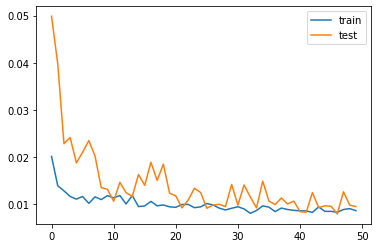

ValueError: operands could not be broadcast together with shapes (35063,16) (12,) (35063,16) 

In [35]:
%%time 

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)